In [577]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 22 14:13:15 2023

@author: souchaud
"""
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import sys
import shutil
import functions_analyze as lib
from scipy.signal import find_peaks

In [578]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device for torch operations:", device)

Device for torch operations: cpu


In [579]:
def force_field_inbox(coordinates_diff, distances, Req, R0, Frep, Fadh,
                      coeff_a = None, coeff_rep = None):
    """
    Calculate the force field within the focal box.

    Parameters
    ----------
    - coordinates_diff: Tensor representing the positions of particles in the focal box.

    Returns
    -------
    - force_field: Tensor representing the force field within the focal box.

    """  
    Rlim = 0.000001
    R = torch.norm(coordinates_diff, dim=2)
    # prevents the repulsion force from exploding when approaching its maximum value
    R = torch.where(R > Rlim*torch.ones(1, device=device),
                  R, Rlim*torch.ones(1, device=device)).to(device)
    
    ###########  R**2 adhesion force ###########
    # a = coeff_a
    # b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    # c = -Req*(a*Req+ (Fadh-a*(R0**2-Req**2))/(R0-Req))
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -(a*R**2+b*R+c), torch.zeros_like(R)).to(device)
    
    ########### a*R**alpha + b ############
    alpha = coeff_a
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -(Fadh/((R0**alpha)-(Req**alpha)))*((R**alpha)-(Req**alpha)), torch.zeros_like(R)).to(device)
    force = torch.where(torch.logical_and(R < R0, R > Req),
                        function_adh(R, Req, R0, Fadh, alpha, coeff_a=coeff_a), torch.zeros_like(R)).to(device)

    # The repulsion force is calculated wherever R<Req
    ########### Linear adhesion force ########### 
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -((Fadh/(R0-Req))*R-Fadh*Req/(R0-Req)), torch.zeros_like(R)).to(device)

    ###########  Repulsion force linear ########## 
    # force = torch.where(R < Req,
    #                     - Frep*R*(1/Req-1/R), force).to(device)
    ########### Repulsion forces in 1/R ########### 
    force = torch.where(R <= Req,
                        - Frep*coeff_rep*(1/Req-1/R), force).to(device)

    force_field = torch.sum(force[:, :, None] *
                            torch.nn.functional.normalize(coordinates_diff, dim = 2), axis=1)

    return force_field


def function_adh(R, Req, R0, Fadh, alpha, coeff_a):
    # a = coeff_a
    # b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    # c = -Req*(a*Req+ (Fadh-a*(R0**2-Req**2))/(R0-Req))
    # return -(a*R**2+b*R+c)
    return -((Fadh/(R0-Req))*R-Fadh*Req/(R0-Req))

# def function_adh(R, Req, R0, Fadh, alpha,):
#     return -(Fadh/((R0-Req)**alpha))*((R-Req)**alpha)

def autovel(dX, n, tau, noise, dt, persistence):
    """
    Calcule la nouvelle direction des cellules basée sur leur déplacement,
    leur direction précédente, le bruit, le temps caractéristique tau, et la persistance.
    
    Paramètres
    ----------
    dX : Tensor
        Le déplacement des cellules durant le dernier intervalle de temps.
    n : Tensor
        La direction actuelle des cellules.
    tau : float
        Le temps caractéristique pour l'alignement de la polarisation dans
        la direction définie par la vitesse = dX/dt.
    noise : float
        L'intensité du bruit ajouté pour simuler des perturbations aléatoires
        dans la direction des cellules.
    dt : float
        L'intervalle de temps entre les mises à jour des positions.
    persistence : float
        Le facteur de persistance qui influence à quel point la direction actuelle
        est conservée. Valeur entre 0 (pas de persistance, direction entièrement aléatoire)
        et 1 (persistance complète, pas de changement de direction).

    Retour
    -------
    n : Tensor
        La nouvelle direction des cellules après mise à jour.
    """
    # Compute the angle between the input vector and the x-axis
    theta = torch.atan2(dX[:, 1], dX[:, 0]).to(device)
    
    # Normalize the input vector
    dX_norm = torch.nn.functional.normalize(dX, dim=1) * 0.9999999
    if persistence == 1:
        persistence = 0.9999999
    # Compute the change in angle based on the orientation vector (n)
    dtheta = torch.arcsin((n[:, 0] * dX_norm[:, 1] - n[:, 1] * dX_norm[:, 0])) * dt / (tau * (1 - persistence))
    
    # Generate random noise for angle perturbation
    rnd = noise * (2 * math.pi * (torch.rand(len(dX), 1, device=device) - 0.5)) * np.sqrt(dt) * (1 - persistence)
    
    # Update the angle by adding the change in angle, random noise, and the previous angle
    theta += dtheta + rnd[:, 0]
    
    # Calculate the weighted average of the new direction and the old direction
    new_dir_x = torch.cos(theta) * (1 - persistence) + n[:, 0] * persistence
    new_dir_y = torch.sin(theta) * (1 - persistence) + n[:, 1] * persistence
    
    # Normalize the new direction vector
    new_dir_norm = torch.sqrt(new_dir_x**2 + new_dir_y**2)
    n[:, 0].copy_(new_dir_x / new_dir_norm)
    n[:, 1].copy_(new_dir_y / new_dir_norm)
    
    # Calculez l'angle final basé sur la direction finale normalisée
    theta_final = torch.atan2(new_dir_y / new_dir_norm, new_dir_x / new_dir_norm)

    # Retournez la nouvelle direction n et l'angle final theta_final
    return n, theta_final


def plot_environment(cells, space_size,req, path_saving=None, iteration=None):
    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, space_size)
    plt.ylim(0, space_size)

    # Combine cells from both populations
    all_cells = population1.cells + population2.cells

    # Extract x and y coordinates
    x = [cell.position[0].item() for cell in all_cells]
    y = [cell.position[1].item() for cell in all_cells]

    # Create a list of colors corresponding to each cell
    colors = ['blue'] * len(population1.cells) + \
        ['red'] * len(population2.cells)

    # Plot all cells at once with the specified colors
    axis.scatter(x, y, s=3, color=colors,alpha=0.5, rasterized=True)

    # plt.title('Cell Movement')
    plt.xlabel('X position (micrometers)')
    plt.ylabel('Y position (micrometers)')
    # plt.axis('off')
    plt.axis('off')
    plt.savefig(f'{path_saving}image_{iteration}.png',
                bbox_inches='tight', dpi=400, pad_inches = 0)

    # plt.show()
    plt.close()
    # print(iteration)


def plot_function(pas, Req, R0, Frep, Fadh, a, coeff_rep):

    b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    c = -Req*(a*Req + (Fadh-a*(R0**2-Req**2))/(R0-Req))

    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, R0)
    plt.ylim(-Frep, Fadh)

    print("Req = ", Req)
    print("R0 = ", R0)
    print("Fadh = ", Fadh)
    print("Frep = ", Frep)

    axis.plot(np.arange(pas, Req, pas), [
              R*Frep*(1/Req-1/R) for R in np.arange(pas, Req, pas)], label='rep Mathieu')
    axis.plot(np.arange(pas, Req, pas), [
              Frep*coeff_rep*(1/Req-1/R) for R in np.arange(pas, Req, pas)], label='rep Alex')

    axis.plot(np.arange(Req, R0, pas), [
              (Fadh/(R0-Req))*(R-Req) for R in np.arange(Req, R0, pas)], label='adhline')
    axis.plot(np.arange(Req, R0, pas), [-function_adh(R, Req, R0, Fadh, alpha=0.5, coeff_a=30)
                                        for R in np.arange(Req, R0, pas)], alpha=0.5, label='adh_Alex')
    axis.plot(np.arange(Req, R0, pas), [(a*R**2+b*R+c)
              for R in np.arange(Req, R0, pas)], label="square")

    # (Fadh/(R0-Req))*R+Fadh*Req/(R0-Req)

    plt.xlabel('Distance')
    plt.ylabel('Force')
    plt.legend()
    plt.show()

In [580]:
class CellAgent:
    def __init__(self, position, velocity, velocity_magnitude, persistence, space_size):
        # We add the inital position to make some calc later.
        self.position_init = position.clone().to(device)
        self.position = position.clone().to(device)
        self.velocity = velocity.clone().to(device)
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.space_size = space_size
        self.direction = torch.nn.functional.normalize(velocity, p=2, dim=0)


In [581]:
class Population:
    def __init__(self, num_cells, space_size, velocity_magnitude, persistence, min_distance):
        self.num_cells = num_cells
        self.space_size = space_size
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.min_distance = min_distance
        self.cells = []
        self.initialize_cells()

    def initialize_cells(self):
        positions = torch.rand((self.num_cells, 2), device=device) * self.space_size
        directions = torch.nn.functional.normalize(torch.empty_like(positions).uniform_(-1, 1), dim=1)
        
        # Générez les vitesses initiales selon une distribution gaussienne
        ecart_type_vitesse = 0.9  # À ajuster selon vos besoins
        vitesses_gaussiennes = torch.normal(mean=self.velocity_magnitude, std=ecart_type_vitesse, size=(self.num_cells,))
        
        # Appliquez les vitesses gaussiennes aux directions pour obtenir les vecteurs de vitesse
        velocities = directions * vitesses_gaussiennes[:, None]

        if self.min_distance != 0:
          # Create a grid with cell size equal to the minimum distance
          grid_size = int(np.ceil(self.space_size / self.min_distance))
          grid = [[[] for _ in range(grid_size)] for _ in range(grid_size)]

          valid_positions = []
          for i in range(self.num_cells):
              valid = True

              # Compute the cell's grid indices
              grid_x = int(positions[i, 0] / self.min_distance)
              grid_y = int(positions[i, 1] / self.min_distance)

              # Check neighboring cells in the grid
              for dx in [-1, 0, 1]:
                  for dy in [-1, 0, 1]:
                      nx = grid_x + dx
                      ny = grid_y + dy

                      # Check if the neighboring grid cell is valid
                      if 0 <= nx < grid_size and 0 <= ny < grid_size:
                          for cell_pos in grid[nx][ny]:
                              # Check the distance between the current cell and the neighboring cells
                              if torch.norm(positions[i] - cell_pos) < self.min_distance:
                                  valid = False
                                  break
                      if not valid:
                          break
                  if not valid:
                      break
              if valid:
                  # Add the cell position to the grid
                  grid[grid_x][grid_y].append(positions[i])
                  valid_positions.append(positions[i])
              else:
                  # Generate a new random position until a valid one is found
                  while not valid:
                      positions[i] = torch.rand((1, 2), device=device) * self.space_size

                      # Compute the updated cell's grid indices
                      grid_x = int(positions[i, 0] / self.min_distance)
                      grid_y = int(positions[i, 1] / self.min_distance)

                      # Check neighboring cells in the grid
                      valid = True
                      for dx in [-1, 0, 1]:
                          for dy in [-1, 0, 1]:
                              nx = grid_x + dx
                              ny = grid_y + dy

                              # Check if the neighboring grid cell is valid
                              if 0 <= nx < grid_size and 0 <= ny < grid_size:
                                  for cell_pos in grid[nx][ny]:
                                      # Check the distance between the current cell and the neighboring cells
                                      if torch.norm(positions[i] - cell_pos) < self.min_distance:
                                          valid = False
                                          break
                              if not valid:
                                  break
                          if not valid:
                              break

                  # Add the cell position to the grid
                  grid[grid_x][grid_y].append(positions[i])
                  valid_positions.append(positions[i])
        else :
          valid_positions = [positions[i] for i in range(len(positions))]

        # self.cells = [CellAgent(position, velocities[i], self.velocity_magnitude, self.persistence, self.space_size) for i, position in enumerate(valid_positions)]
        self.cells = [CellAgent(position, directions[i] * vitesses_gaussiennes[i], vitesses_gaussiennes[i], self.persistence, self.space_size) for i, position in enumerate(positions)]


In [582]:
class Surface:
    def get_friction(self, position):
        friction = torch.empty(1).uniform_(0, 0.2).to(device)
        return friction.item()

882 cells
Req =  1.1
R0 =  1.6
Fadh =  7
Frep =  40


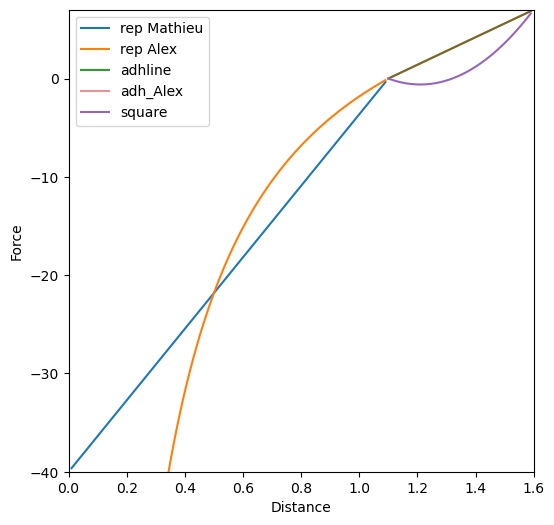

In [583]:
# In[Simulation parameters]
# Space parameters
SPACE_SIZE = 2048 #1308 # Micrometers
# time settings
TIME_SIMU = 90 # time simulation in minutes
DELTA_T = 15/60 # 0.01 # simulation interval in minutes
PLOT_INTERVAL = 1 # 25
# simulation parameters
MU = 1  # mobility in min.kg-1
F_REP = 40  # repulsive strength
F_ADH = 7 # 3 #4 #attractive strength force kg.um.min-2
R_EQ = 1.1 # 11  # equilibrium radius in um
R_0 = 1.6 # 16  # interaction radius in um
MIN_DISTANCE_INIT = R_EQ
NOISE = 10  # noise intensity
TAU = 5 # characteristic time for the polarization to align in the scattering direction defined by v=dr/dt = time
PERSISTENCE_POP1 = 0.2
PERSISTENCE_POP2 = 0.6
# Cells definition
PACKING_FRACTION = 0.0002
N_CELLS = int((PACKING_FRACTION*SPACE_SIZE**2)/
              (math.pi*((R_EQ/2)**2)))  # number of particles
# N = 2000
print(N_CELLS, "cells")
velocity_magnitude_pop1 = 5 #um/min
velocity_magnitude_pop2 = 5 # um/min

COEFF_CARRE = 50
COEFF_REP = 0.5
plot_function(pas=0.01, Req=R_EQ, R0=R_0, Frep=F_REP,
              Fadh=F_ADH, a=COEFF_CARRE, coeff_rep=COEFF_REP)

In [584]:
# In[Definition of the populations]
population1 = Population(num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop1,\
                         persistence=PERSISTENCE_POP1,\
                         min_distance=MIN_DISTANCE_INIT)
population2 = Population(num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop2,\
                         persistence=PERSISTENCE_POP2,\
                         min_distance=MIN_DISTANCE_INIT)

cells = population1.cells + population2.cells

surface = Surface()

In [585]:
# In[initialisation]
positions = torch.stack([cell.position_init for cell in cells])
V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device = device).unsqueeze(1)
direction = torch.stack([cell.direction for cell in cells])
positions = torch.stack([cell.position for cell in cells])
PATH = f'/Users/souchaud/Desktop/simu/v1{velocity_magnitude_pop1}v2{velocity_magnitude_pop2}a{COEFF_CARRE}coefrep{COEFF_REP}fadh{F_ADH}frep{F_REP}/'
if not os.path.exists(PATH):
    os.mkdir(PATH)
else :
    print("WARNING : FOLDER DOES ALREADY EXIST!")
    sys.exit(0)
plot_environment(cells, space_size= SPACE_SIZE, req=R_EQ,
                 path_saving=PATH, iteration = 0)

In [586]:
# In[Simulation]
import pandas as pd
# Création du DataFrame vide
columns = ['frame', 'particle', 'x', 'y']
data_frame = pd.DataFrame(columns=columns)
time = 0
iteration = 1
MAX_DISTANCE = np.sqrt(2*(SPACE_SIZE/2)**2)

while time < TIME_SIMU :
    #Paiwise distance.
    coordinates_diff = ((positions[:, None, :] - positions[None, :, :]))
    coordinates_diff = torch.remainder(coordinates_diff-(SPACE_SIZE/2),SPACE_SIZE)-(SPACE_SIZE/2)
    distances = torch.stack([torch.norm(coordinates_diff[i], dim=1)
                             for i in range(0, len(coordinates_diff))])
    is_greater_than_max = torch.any(distances > MAX_DISTANCE)

    if is_greater_than_max:
      print("At least one distance is greater than the max distance.")

    # force_field calculation
    force_field = force_field_inbox(coordinates_diff, distances, Req=R_EQ,
                                    R0=R_0, Frep=F_REP, Fadh=F_ADH,
                                    coeff_a = COEFF_CARRE, coeff_rep = 0.5)
    # displacement computing
    fluctuations = (torch.rand(V0.shape, device=V0.device)*4) - 0.5*4
    displacement = MU * force_field * DELTA_T +\
                   (V0 + fluctuations) * direction * DELTA_T
    # cells position evolution
    positions += displacement

    # border conditions
    positions = torch.remainder(positions, SPACE_SIZE)

    for cell, position, direct in zip(cells, positions, direction):
        cell.position = position.to(device)
        cell.direction = direct.to(device)
        # print(cell, position, direct)
    # direction update for next step
    # direction = autovel(displacement, direction, TAU, NOISE, DELTA_T, persistence=PERSISTENCE)
    # direction = autovel2( direction, noise)
    # Boucle pour la mise à jour de la population 1
    theta_cells = []
    for i, cell in enumerate(population1.cells):
        # # Extraire le déplacement spécifique à cette cellule
        # cell_displacement = displacement[i, :].unsqueeze(0)  # Ajoute une dimension pour conserver la forme [1, 2]
        # # Mettre à jour la direction de la cellule
        # cell.direction, theta = autovel(cell_displacement, cell.direction.unsqueeze(0), TAU, NOISE, DELTA_T, persistence=cell.persistence).squeeze(0)
        # # Notez l'utilisation de unsqueeze(0) pour ajouter une dimension factice à 'cell.direction', et squeeze(0) pour la retirer après
        # theta_cells.append(theta)
       # Extraire le déplacement spécifique à cette cellule
        cell_displacement = displacement[i, :].unsqueeze(0)  # Ajoute une dimension pour conserver la forme [1, 2]
        
        # Appeler autovel et récupérer la nouvelle direction et l'angle
        new_direction, theta = autovel(cell_displacement, cell.direction.unsqueeze(0), TAU, NOISE, DELTA_T, persistence=cell.persistence)
        
        # S'il y a besoin d'utiliser .squeeze(0) sur new_direction, assurez-vous de l'appliquer correctement
        cell.direction = new_direction.squeeze(0)  # Utiliser .squeeze(0) si new_direction a une dimension superflue
        theta_cells.append(theta.item())  # Supposer que vous voulez convertir theta en un nombre Python

    # Faire de même pour la population 2
    for i, cell in enumerate(population2.cells):
        # Extraire le déplacement spécifique à cette cellule
        cell_displacement = displacement[i, :].unsqueeze(0)  # Ajoute une dimension pour conserver la forme [1, 2]
        
        # Appeler autovel et récupérer la nouvelle direction et l'angle
        new_direction, theta = autovel(cell_displacement, cell.direction.unsqueeze(0), TAU, NOISE, DELTA_T, persistence=cell.persistence)
        
        # S'il y a besoin d'utiliser .squeeze(0) sur new_direction, assurez-vous de l'appliquer correctement
        cell.direction = new_direction.squeeze(0)  # Utiliser .squeeze(0) si new_direction a une dimension superflue
        theta_cells.append(theta.item())  # Supposer que vous voulez convertir theta en un nombre Python
    # plot the result
    marker_radius = 1.1
    marker_size = (np.pi) * marker_radius ** 2
    if iteration % PLOT_INTERVAL == 0:
      plot_environment(cells, path_saving = PATH, space_size = SPACE_SIZE, req=R_EQ, iteration = iteration)

    # À la fin de chaque itération de la boucle, enregistrez les coordonnées
    temp_data = []
    for i, position in enumerate(positions):
        temp_data.append([time, i, position[0].item(), position[1].item()])
    
    # Ajouter les données temporairement stockées au DataFrame
    temp_df = pd.DataFrame(temp_data, columns=columns)
    # Ajouter les angles à temp_df avant de concaténer
    temp_df['theta'] = theta_cells

    # Ensuite concaténer temp_df à data_frame
    data_frame = pd.concat([data_frame, temp_df], ignore_index=True)

    time += DELTA_T
    # print(time)
    iteration += 1

/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_39973/1116857684.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pd.concat([data_frame, temp_df], ignore_index=True)


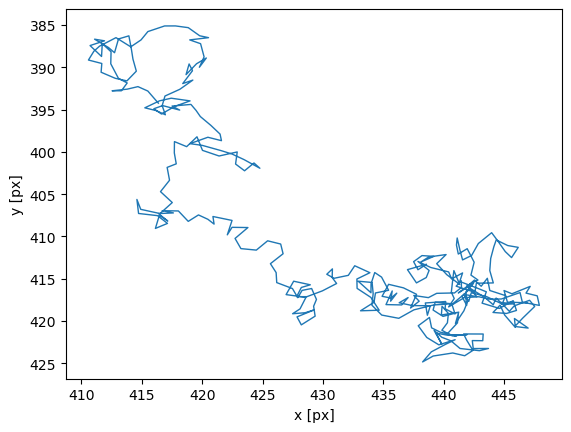

In [587]:
import trackpy as tp
tp.plot_traj(data_frame[data_frame['particle']==0])
data_frame.groupby('particle')

In [588]:
# # Calculer les différences de position
# data_frame['dx'] = data_frame.groupby('particle')['x'].diff().fillna(0)
# data_frame['dy'] = data_frame.groupby('particle')['y'].diff().fillna(0)

# # Calculer la distance parcourue à chaque pas de temps
# data_frame['distance'] = (data_frame['dx']**2 + data_frame['dy']**2).pow(0.5)

# # Calculer la vitesse pour chaque pas de temps
# data_frame['vitesse'] = data_frame['distance'] / DELTA_T

# # Calculer la vitesse moyenne pour chaque particule
# vitesse_moyenne = data_frame.groupby('particle')['vitesse'].mean()

In [589]:
# # Tracer l'histogramme des vitesses moyennes
# plt.hist(vitesse_moyenne, bins=10000)

# # Ajuster les limites de l'axe x pour correspondre à la plage de l'histogramme
# plt.xlim(0, 20)

# # Ajouter des titres et des étiquettes
# plt.title('Histogramme des vitesses moyennes')
# plt.xlabel('Vitesse moyenne')
# plt.ylabel('Nombre de particules')

# # Afficher l'histogramme
# plt.show()

In [590]:
def adjust_positions_xy(group):
    SPACE_SIZE_X = SPACE_SIZE  # La taille de l'espace toroïdal en x
    SPACE_SIZE_Y = SPACE_SIZE  # La taille de l'espace toroïdal en y, ajustez selon votre espace
    # Calculer les différences pour obtenir 'dx' et 'dy'
    group['dx'] = group['x'].diff().fillna(0)
    group['dy'] = group['y'].diff().fillna(0)
    
    # Initialiser de nouvelles colonnes pour les positions ajustées
    group['adjusted_x'] = group['x'].copy()
    group['adjusted_y'] = group['y'].copy()
    
    # Ajuster les positions en x
    for i in range(1, len(group)):
        if group.iloc[i]['dx'] > SPACE_SIZE_X / 2:
            group['adjusted_x'].iloc[i:] -= SPACE_SIZE_X
        elif group.iloc[i]['dx'] < -SPACE_SIZE_X / 2:
            group['adjusted_x'].iloc[i:] += SPACE_SIZE_X
            
    # Ajuster les positions en y
    for i in range(1, len(group)):
        if group.iloc[i]['dy'] > SPACE_SIZE_Y / 2:
            group['adjusted_y'].iloc[i:] -= SPACE_SIZE_Y
        elif group.iloc[i]['dy'] < -SPACE_SIZE_Y / 2:
            group['adjusted_y'].iloc[i:] += SPACE_SIZE_Y
            
    # Calculer dx et dy ajustés après correction
    group['adjusted_dx'] = group['adjusted_x'].diff().fillna(0)
    group['adjusted_dy'] = group['adjusted_y'].diff().fillna(0)
    
    return group

# Assurez-vous que votre DataFrame df_final contient une colonne 'y' pour chaque position y
# Par exemple, ajouter: df_final['y'] = [valeur_y1, valeur_y2, ...] pour chaque particule

# Appliquer la fonction à chaque groupe de particules et concaténer les résultats
df_adjusted = data_frame.groupby('particle').apply(adjust_positions_xy).reset_index(drop=True)

df_adjusted['x'] = df_adjusted['adjusted_x']
df_adjusted['y'] = df_adjusted['adjusted_y']


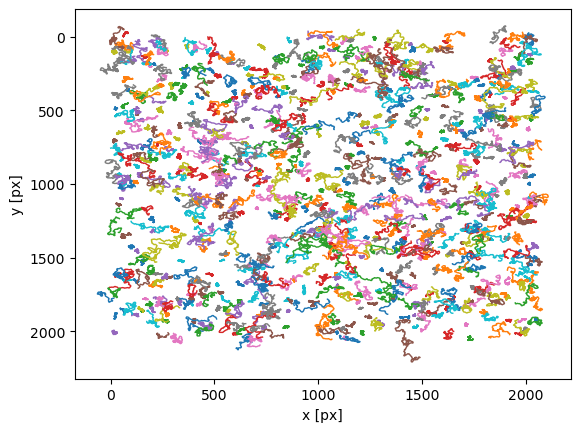

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [591]:
tp.plot_traj(traj=df_adjusted)

In [592]:
df_adjusted.drop(['adjusted_x', 'adjusted_y', 'adjusted_dx', 'adjusted_dy'], axis=1, inplace=True)

In [593]:
# Calculer les différences de position
df_adjusted['dx'] = df_adjusted.groupby('particle')['x'].diff().fillna(0)
df_adjusted['dy'] = df_adjusted.groupby('particle')['y'].diff().fillna(0)

# Calculer la distance parcourue à chaque pas de temps
df_adjusted['distance'] = (df_adjusted['dx']**2 + df_adjusted['dy']**2).pow(0.5)

# Calculer la vitesse pour chaque pas de temps
df_adjusted['vitesse'] = df_adjusted['distance'] / DELTA_T

# Calculer la vitesse moyenne pour chaque particule
vitesse_moyenne = df_adjusted.groupby('particle')['vitesse'].mean()

In [594]:
df_adjusted

,frame,particle,x,y,theta,dx,dy,distance,vitesse
0,0,0,416.370270,394.248688,-2.117024,0.000000,0.000000,0.000000,0.000000
1,0.25,0,415.498840,392.815216,-2.573948,-0.871429,-1.433472,1.677567,6.710267
2,0.5,0,414.679504,392.292755,2.817231,-0.819336,-0.522461,0.971739,3.886956
3,0.75,0,413.791656,392.591278,2.988523,-0.887848,0.298523,0.936691,3.746764
4,1.0,0,412.535706,392.785034,-0.001959,-1.255951,0.193756,1.270808,5.083234
...,...,...,...,...,...,...,...,...,...
317515,88.75,881,795.316650,828.019836,1.782122,-1.384949,1.108521,1.773951,7.095802
317516,89.0,881,795.036804,829.324402,2.326180,-0.279846,1.304565,1.334243,5.336973
317517,89.25,881,794.262939,830.146118,2.803307,-0.773865,0.821716,1.128753,4.515014
317518,89.5,881,792.627625,830.721436,3.051947,-1.635315,0.575317,1.733564,6.934257


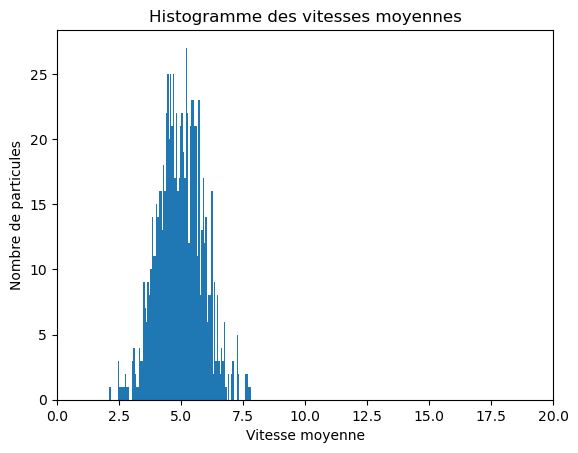

In [595]:
# Tracer l'histogramme des vitesses moyennes
plt.hist(vitesse_moyenne, bins=100)

# Ajuster les limites de l'axe x pour correspondre à la plage de l'histogramme
plt.xlim(0, 20)

# Ajouter des titres et des étiquettes
plt.title('Histogramme des vitesses moyennes')
plt.xlabel('Vitesse moyenne')
plt.ylabel('Nombre de particules')

# Afficher l'histogramme
plt.show()

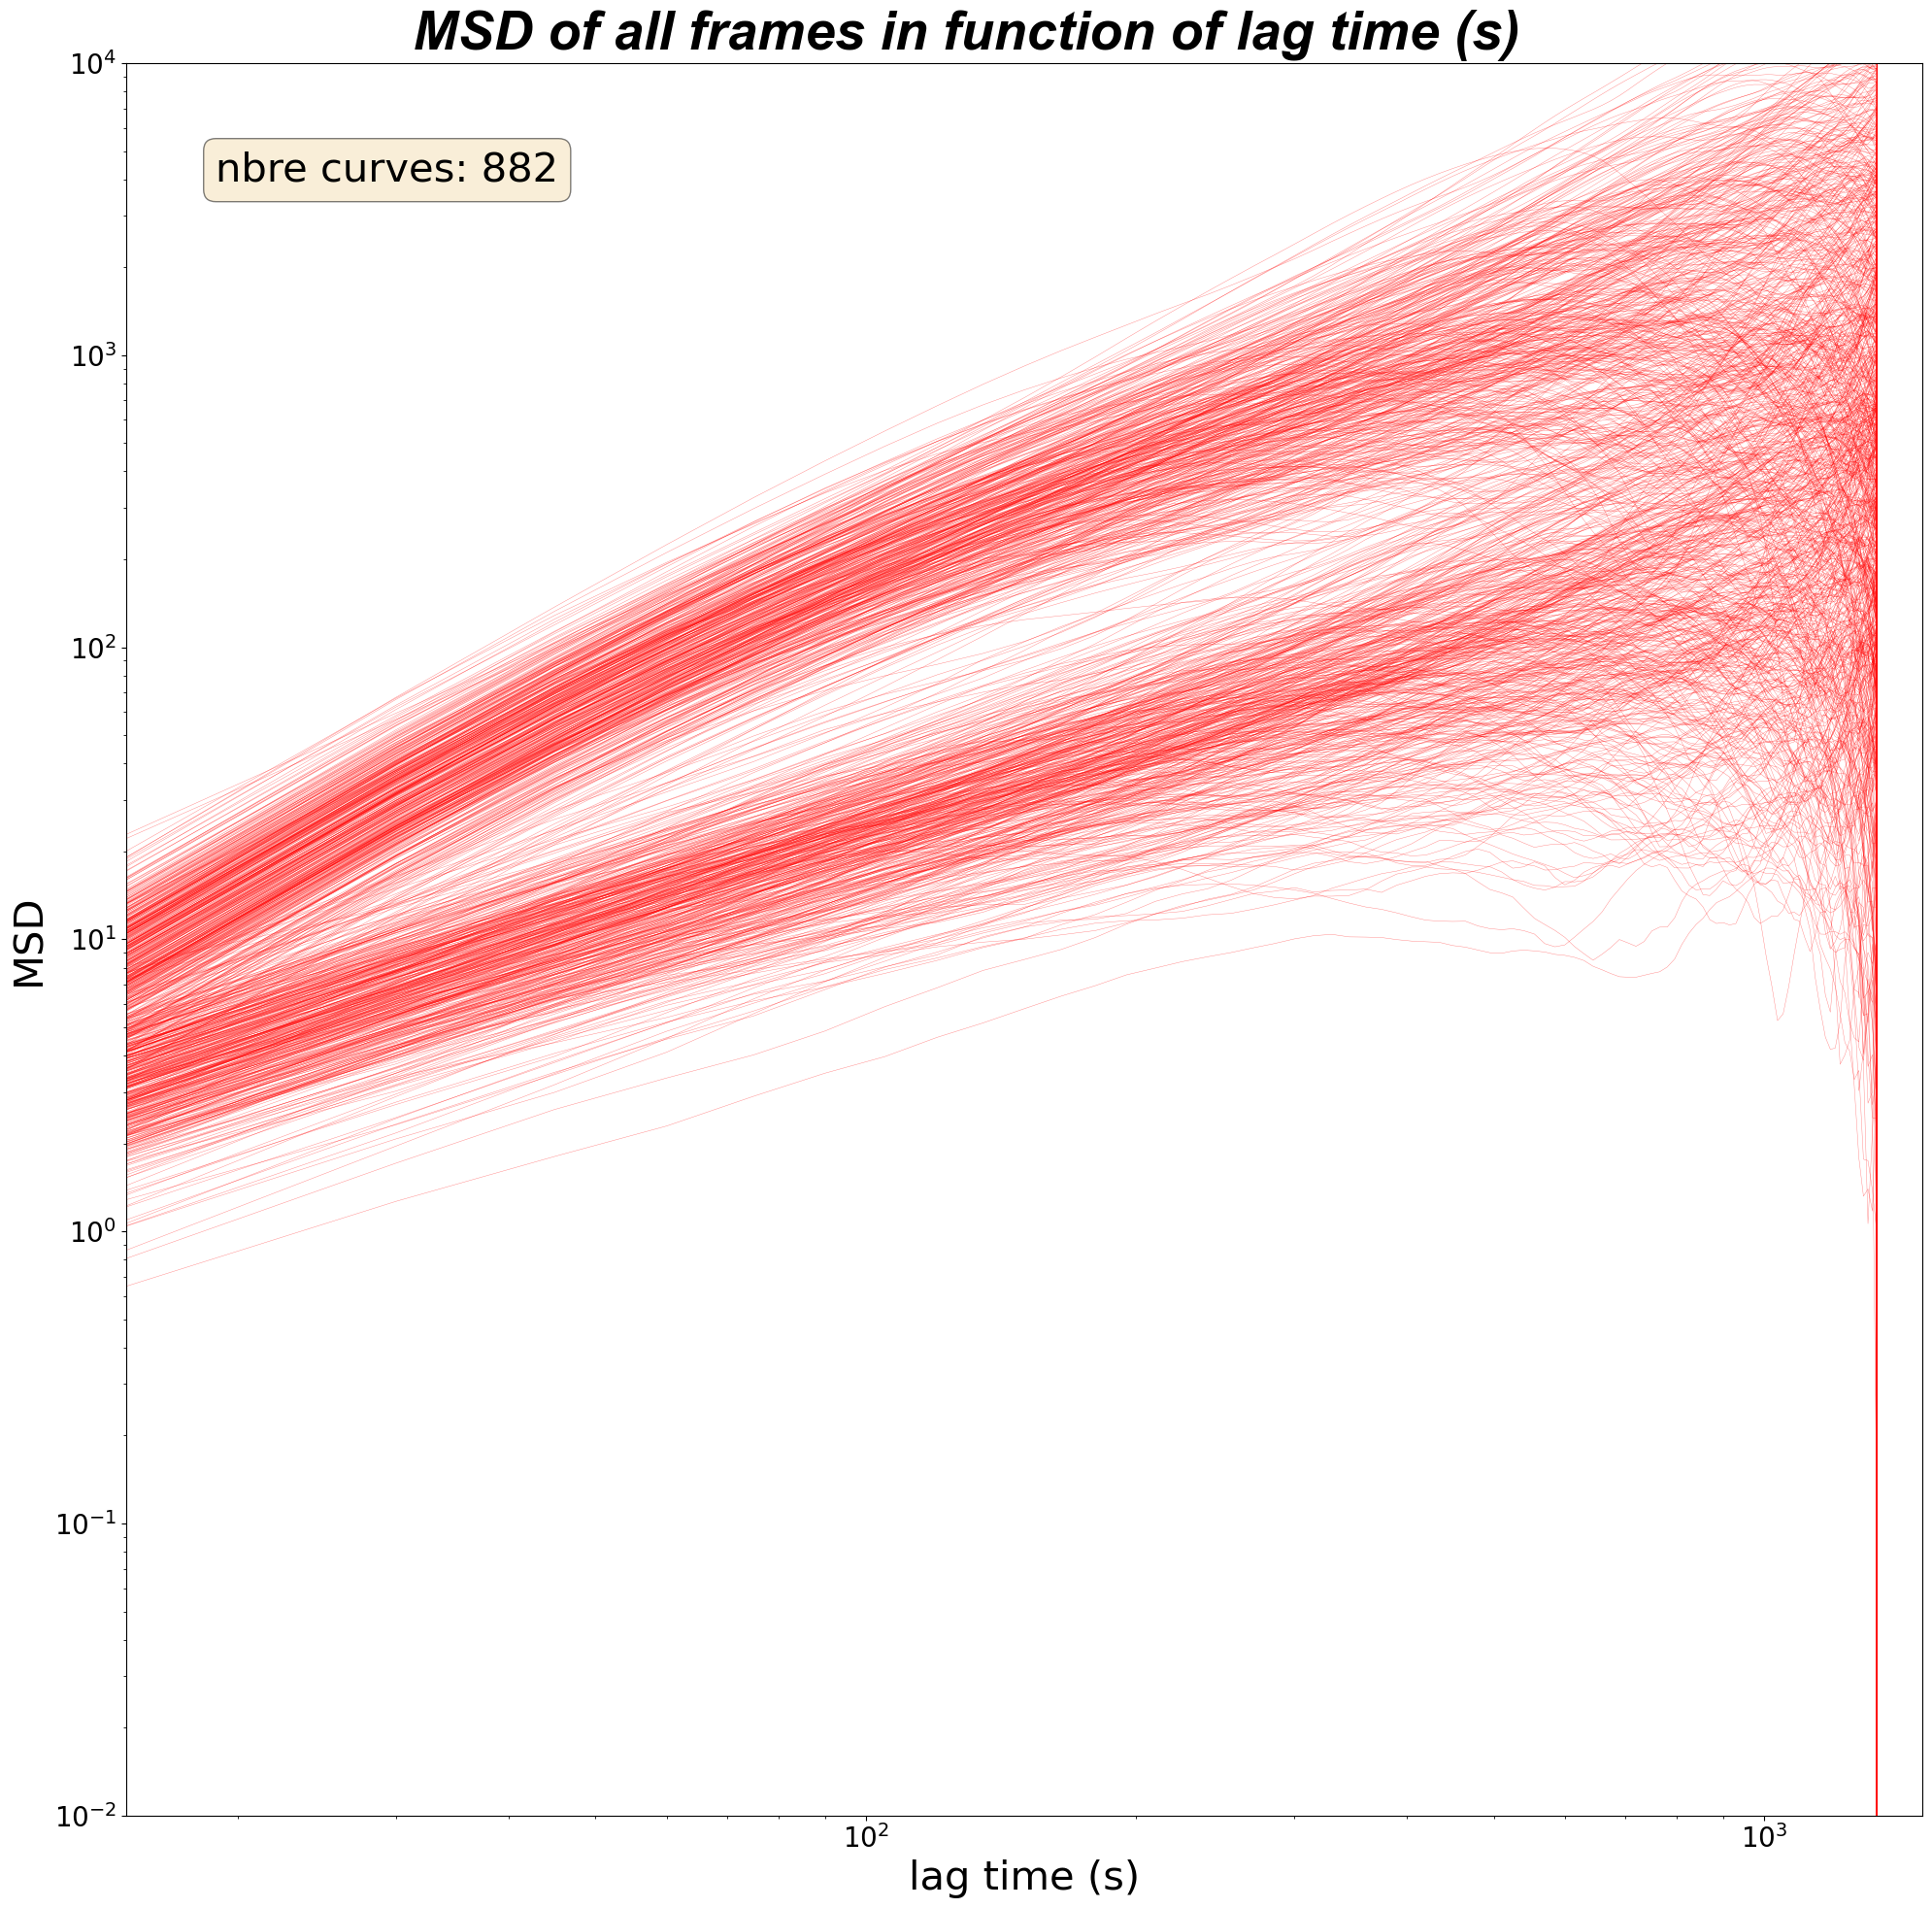

In [596]:
def plot_msd(msd, fps, name="MSD of all frames in function of lag time (s)",
             color_plot: str = 'red', save=False, pathway_saving=None,
             alpha=0.05, linewidth=0.01, img_type='jpg'):
    """
    Plot the mean square displacement (MSD) for a specific need.

    Parameters
    ----------
    msd : DataFrame
        DataFrame containing the MSD values.
    fps : float
        Number of frames per second.
    name : str, optional
        Title of the plot. Default is "MSD of all frames in function of lag time (s)".
    save : bool, optional
        Whether to save the plot or not. Default is False.
    pathway_saving : str, optional
        Absolute path to save the plot. Default is None.

    Returns
    -------
    None.

    """
    # Get the number of curves from the number of columns in the MSD DataFrame
    nbr_curves = len(msd.columns)

    # # Set the index
    # msd = msd.set_index("lag time [s]")

    # Create a new figure and axis object
    fig, axis = plt.subplots(figsize=(20, 20))

    # Plot the MSD data on the axis object
    axis.plot(msd, alpha=alpha, linewidth=linewidth, color=color_plot)

    # Set the limits of the x-axis and y-axis
    axis.set_xlim([1 / fps, 100 / fps])
    axis.set_ylim(0.01, 10000)

    # Set the x-axis and y-axis to be on a log scale
    axis.set(xscale="log", yscale="log")

    # Set the x-axis label
    axis.set_xlabel("lag time (s)", fontsize=30)

    # Set the x-axis label
    axis.set_ylabel("MSD", fontsize=30)

    # Add a text box to the plot with the number of curves
    textstr = f"nbre curves: {nbr_curves}"
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    axis.text(0.05, 0.95, textstr, transform=axis.transAxes, fontsize=30,
              verticalalignment="top", bbox=props)

    axis.tick_params(axis='both', which='major', labelsize=20)

    # Set the title of the plot
    fig.suptitle(name, fontsize=40, fontweight="bold", fontstyle='italic', fontname="Arial")

    # Adjust the spacing of the plot
    fig.tight_layout()

    # Save the plot if the "save" parameter is True
    if save:
        fig.savefig(f"{pathway_saving}{name}." + img_type, format=img_type)


IMSD = tp.imsd(df_adjusted, mpp = 0.637, fps = 1/15)


plot_msd(IMSD, fps=1/15, name="MSD of all frames in function of lag time (s)",
             color_plot = 'red', save=False, pathway_saving=None,
             alpha=0.5, linewidth=0.3, img_type='jpg')

# negative slope 0


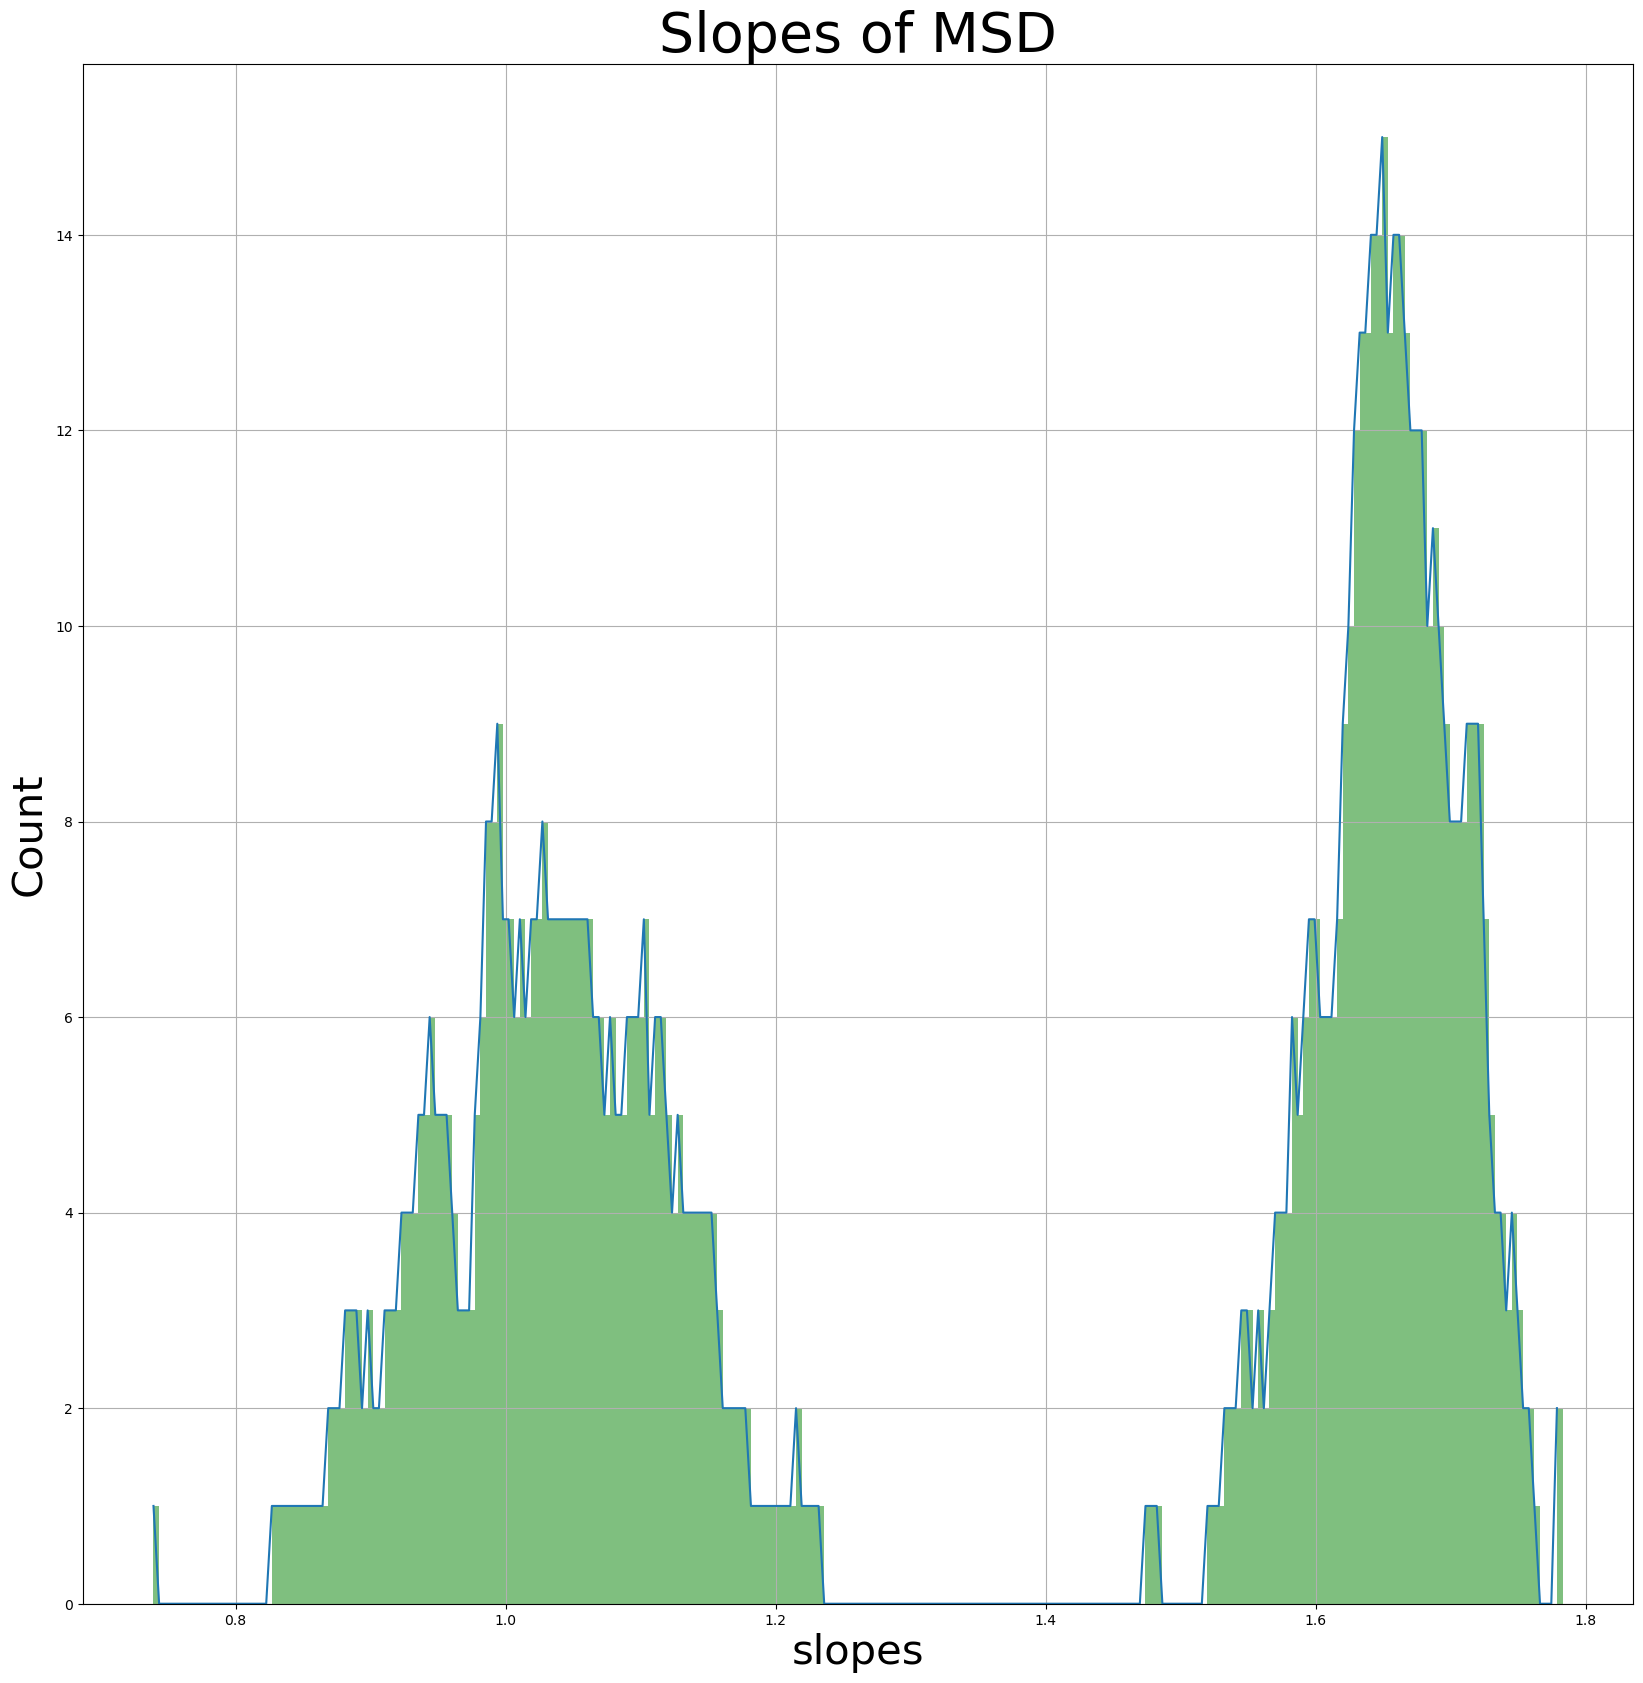

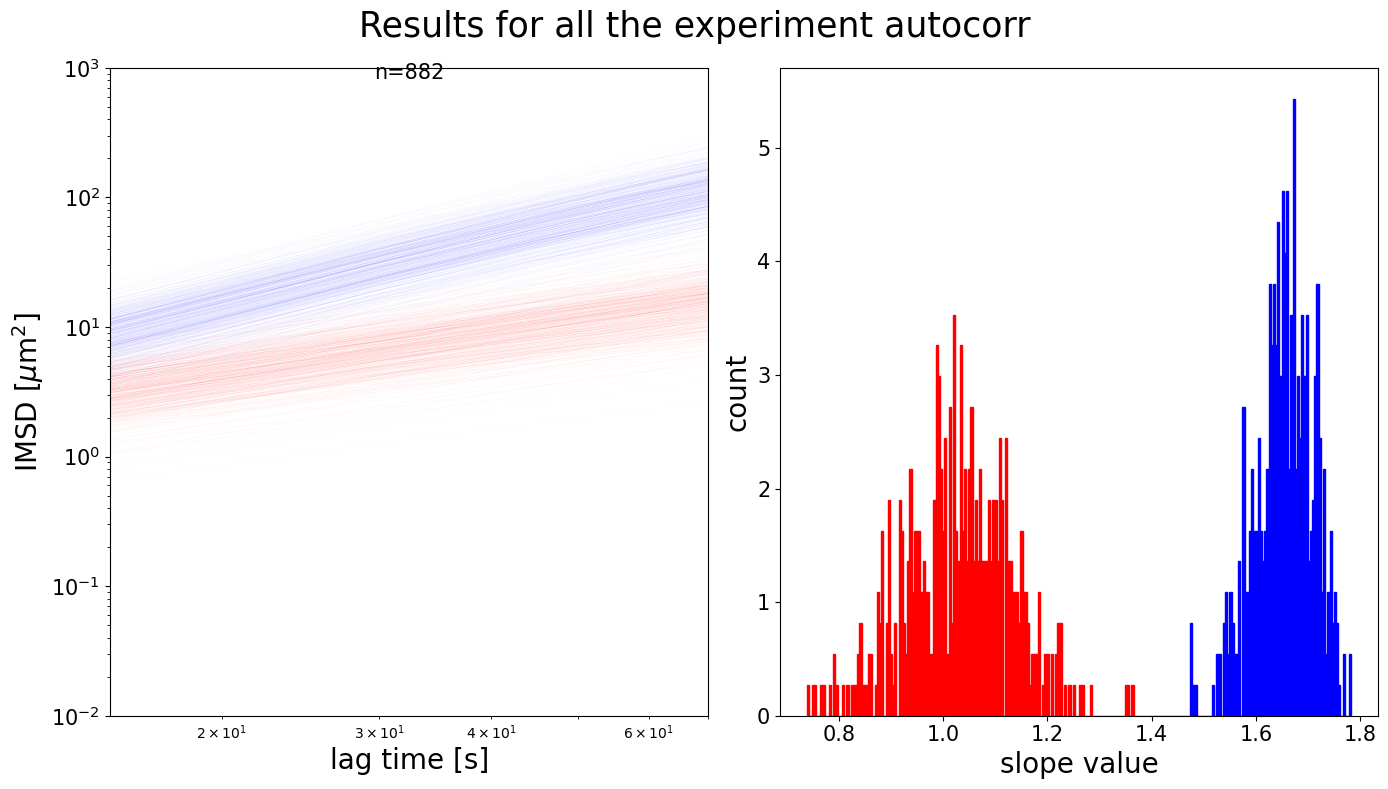

In [597]:
# %% [traj clustering with fit and defining a cutoff]
LAG_TIME_FIT = 5
# plot parameters
IMG_TYPE = 'jpg'
ALPHA = 0.5
LINEWIDTH = 0.1
COLOR_SUP = 'blue'
COLOR_INF = 'red'
color_sup_inf = (COLOR_SUP, COLOR_INF)
# Compute et plot the director factor of the imsd

COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF =\
   lib.traj_clustering_with_fit_cutoff(df_adjusted, imsd=IMSD, hist=True,
                                        lag_time_fit=LAG_TIME_FIT,
                                        micronperpixel=0.637,
                                        fps=1/15, binsize=250,
                                        peak_height=50, peak_width=1,
                                        save=False, pathway_fig=None,
                                        name='all the experiment autocorr', img_type="jpg",
                                        plot=True, color_sup_inf=color_sup_inf,
                                        cutoff_default=1.4
                                        )

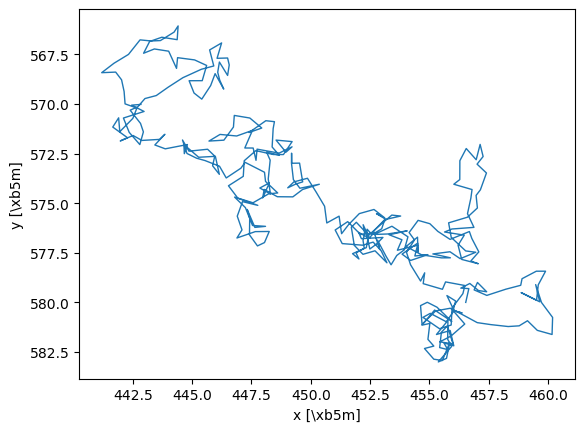

<Axes: xlabel='x [\\xb5m]', ylabel='y [\\xb5m]'>

In [598]:
tp.plot_traj(df_adjusted[df_adjusted['particle']==352], mpp=0.637, fps=15/60)

In [599]:
df_adjusted

,frame,particle,x,y,theta,dx,dy,distance,vitesse
0,0,0,416.370270,394.248688,-2.117024,0.000000,0.000000,0.000000,0.000000
1,0.25,0,415.498840,392.815216,-2.573948,-0.871429,-1.433472,1.677567,6.710267
2,0.5,0,414.679504,392.292755,2.817231,-0.819336,-0.522461,0.971739,3.886956
3,0.75,0,413.791656,392.591278,2.988523,-0.887848,0.298523,0.936691,3.746764
4,1.0,0,412.535706,392.785034,-0.001959,-1.255951,0.193756,1.270808,5.083234
...,...,...,...,...,...,...,...,...,...
317515,88.75,881,795.316650,828.019836,1.782122,-1.384949,1.108521,1.773951,7.095802
317516,89.0,881,795.036804,829.324402,2.326180,-0.279846,1.304565,1.334243,5.336973
317517,89.25,881,794.262939,830.146118,2.803307,-0.773865,0.821716,1.128753,4.515014
317518,89.5,881,792.627625,830.721436,3.051947,-1.635315,0.575317,1.733564,6.934257


In [600]:
import numpy as np
df = df_adjusted.copy()

# Calculer l'angle de déplacement en radians
df['angle_radians'] = np.arctan2(df['dy'], df['dx'])

# Optionnel : Convertir l'angle de radians en degrés
df['angle_degrees'] = np.degrees(df['angle_radians'])

# df[['dx', 'dy', 'angle_radians', 'angle_degrees']]

In [601]:
df

,frame,particle,x,y,theta,dx,dy,distance,vitesse,angle_radians,angle_degrees
0,0,0,416.370270,394.248688,-2.117024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.25,0,415.498840,392.815216,-2.573948,-0.871429,-1.433472,1.677567,6.710267,-2.117016,-121.296060
2,0.5,0,414.679504,392.292755,2.817231,-0.819336,-0.522461,0.971739,3.886956,-2.573939,-147.475813
3,0.75,0,413.791656,392.591278,2.988523,-0.887848,0.298523,0.936691,3.746764,2.817235,161.415704
4,1.0,0,412.535706,392.785034,-0.001959,-1.255951,0.193756,1.270808,5.083234,2.988529,171.230091
...,...,...,...,...,...,...,...,...,...,...,...
317515,88.75,881,795.316650,828.019836,1.782122,-1.384949,1.108521,1.773951,7.095802,2.466605,141.326030
317516,89.0,881,795.036804,829.324402,2.326180,-0.279846,1.304565,1.334243,5.336973,1.782107,102.107205
317517,89.25,881,794.262939,830.146118,2.803307,-0.773865,0.821716,1.128753,4.515014,2.326213,133.282211
317518,89.5,881,792.627625,830.721436,3.051947,-1.635315,0.575317,1.733564,6.934257,2.803308,160.617704
